In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

Text(0,0.5,u'$y$')

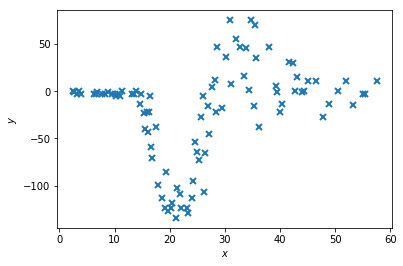

In [2]:
data = np.loadtxt('../data/motor.dat')
X = data[:, 0][:, None]
Xm = np.mean(X)
Xv = np.std(X)
Xnorm = (X - Xm)/Xv
Y = data[:, 1]
fig, ax = plt.subplots()
ax.plot(X, Y, 'x', markeredgewidth=2)
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')

In [3]:
#build the model
k1 = hetero_kernels.RBF(1)
k2 = hetero_kernels.RBF(1)
nonstat = hetero_kernels.NonStationaryLengthscaleRBF()
m = hetero_gpmc.GPMCAdaptLAdaptN(Xnorm, Y[:,None], k1, k2, nonstat)

In [4]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.] [ 0.]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.kern1.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern1.variance,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.lengthscales,[ 1.],None,+ve
adapt_ll_noise_gps.kern2.variance,[ 1.],None,+ve
adapt_ll_noise_gps.nonstat.signal_variance,[ 1.],None,+ve
adapt_ll_noise_gps.signal_variance,[ 1.],None,+ve


In [5]:
m.kern1.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern1.variance.prior = gpflow.priors.Gamma(1., 1.)

m.kern2.lengthscales.prior = gpflow.priors.Gamma(1., 1.)
m.kern2.variance = 0.1
m.kern2.variance.fixed = True

m.nonstat.signal_variance = 100
m.nonstat.signal_variance.fixed = True

In [7]:
m.optimize(maxiter=5000)

      fun: array([ 749.21349936])
 hess_inv: <286x286 LbfgsInvHessProduct with dtype=float64>
      jac: array([  1.36092369e-02,   1.43768497e-02,   7.07110957e-03,
         5.98471097e-03,   3.06184453e-03,   5.05041099e-03,
         3.80793771e-03,   2.21715273e-03,   3.42105472e-03,
         2.20569851e-03,   3.78475150e-03,   3.66932560e-03,
         1.93306349e-03,   1.39126928e-03,   2.03743199e-03,
         2.12930687e-03,   2.25561504e-03,   4.42624680e-03,
         1.79754503e-03,   1.36198658e-03,   2.09327433e-03,
         6.55489126e-04,   1.66955850e-03,   1.14282839e-03,
         1.20421592e-03,   1.53457061e-03,   1.83695971e-03,
         1.64349639e-03,   1.58299032e-03,   1.58995730e-03,
         2.34165281e-03,   6.84975672e-04,   1.78611821e-03,
         1.86462700e-03,   1.21503599e-03,   1.41026853e-03,
         3.20506070e-03,   1.82847717e-03,   3.81794578e-03,
         1.74982743e-03,   2.67796690e-03,   2.13685676e-03,
         4.93170640e-03,   1.50291820e-03

In [8]:
samples = m.sample(300, verbose=True, epsilon=0.01, thin = 2, burn = 200, Lmax = 40)

burn-in sampling started
Iteration:  100 	 Acc Rate:  94.0 %
Iteration:  200 	 Acc Rate:  99.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  96.0 %
Iteration:  200 	 Acc Rate:  95.0 %
Iteration:  300 	 Acc Rate:  98.0 %
Iteration:  400 	 Acc Rate:  97.0 %
Iteration:  500 	 Acc Rate:  96.0 %
Iteration:  600 	 Acc Rate:  98.0 %


In [9]:
m

Name,values,prior,constraint
adapt_ll_noise_gps.V1,[[ -1.75929142e+00] [ -5.11604207e-01] [ -4.48255997e-02] [ 9.62472749e-04] [ 2.46129577e-02] [ 1.47905311e-01] [ 1.21878862e-01] [ 6.19771065e-02] [ 7.60803970e-02] [ 2.79262145e-02] [ 2.84930674e-02] [ 4.26720813e-03] [ -1.74158253e-02] [ -2.10954197e-02] [ -4.82874306e-02] [ -6.51169787e-02] [ -8.04727218e-02] [ -2.29826998e-01] [ -1.42559875e-01] [ -1.28673758e-01] [ -2.69164886e-01] [ -1.17407702e-01] [ -2.13132187e-01] [ -1.37475945e-01] [ -1.44444938e-01] [ -1.55621930e-01] [ -1.73218595e-01] [ -1.83683746e-01] [ -1.80824520e-01] [ -1.82035794e-01] [ -3.52203658e-01] [ -1.65852158e-01] [ -3.26563390e-01] [ -2.95624749e-01] [ -1.79782229e-01] [ -1.77321193e-01] [ -3.37599639e-01] [ -2.07520927e-01] [ -3.69430367e-01] [ -1.84673360e-01] [ -2.45866607e-01] [ -1.98386955e-01] [ -4.59393826e-01] [ -1.61408923e-01] [ -2.93917543e-01] [ -1.91220289e-01] [ -2.50776384e-01] [ -2.58218383e-01] [ -2.46965898e-01] [ -1.77733077e-01] [ -2.28787144e-01] [ -1.77404220e-01] [ -1.67606023e-01] [ -2.86794811e-01] [ -1.77548558e-01] [ -2.15679807e-01] [ -2.72168324e-01] [ -1.62090378e-01] [ -1.47978895e-01] [ -3.07737813e-01] [ -2.94952282e-01] [ -2.92565215e-01] [ -1.51499671e-01] [ -3.21906886e-01] [ -3.07377665e-01] [ -2.53363776e-01] [ -2.14694965e-01] [ -2.79938867e-01] [ -2.26603850e-01] [ -2.24196993e-01] [ -1.66028913e-01] [ -1.58793902e-01] [ -2.79043187e-01] [ -4.21871332e-01] [ -3.53682655e-01] [ -1.35153538e-01] [ -2.51435494e-01] [ -1.90926972e-01] [ -2.72913635e-01] [ -1.93330475e-01] [ -1.41436068e-01] [ -9.78773556e-02] [ -1.96448244e-01] [ -9.12231828e-02] [ -1.00632537e-01] [ -1.33274000e-01] [ -8.01649849e-02] [ -5.25265320e-02] [ -3.93363117e-02] [ -1.56688084e-02] [ -6.09717074e-03] [ -2.30673148e-03] [ -5.03881508e-04] [ -5.71822005e-04]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V2,[[ -1.03097702e+00] [ 3.45090200e+00] [ 1.71949843e+00] [ 2.34481829e+00] [ 3.16125506e+00] [ 4.67343305e+00] [ 1.80478785e+00] [ 1.70783938e+00] [ 4.05348732e+00] [ 1.96480609e+00] [ 2.15378020e+00] [ 2.42211954e+00] [ 1.64160570e+00] [ 1.20881413e+00] [ 1.57575545e+00] [ 1.70743705e+00] [ 1.68992194e+00] [ 3.15069142e+00] [ 1.22085526e+00] [ 9.48256831e-01] [ 2.02115057e+00] [ 1.20289147e+00] [ 1.61253588e+00] [ 1.06876949e+00] [ 9.20323107e-01] [ 8.80165742e-01] [ 8.77532310e-01] [ 8.91437154e-01] [ 8.92820618e-01] [ 9.01145792e-01] [ 1.68652415e+00] [ 1.04384976e+00] [ 1.55255671e+00] [ 1.37158700e+00] [ 8.66547555e-01] [ 7.59536852e-01] [ 1.21300607e+00] [ 8.82079348e-01] [ 1.35844201e+00] [ 7.96072960e-01] [ 8.23114358e-01] [ 6.53128192e-01] [ 1.31169938e+00] [ 6.09241879e-01] [ 7.31780895e-01] [ 5.02556412e-01] [ 5.50584708e-01] [ 5.48306498e-01] [ 5.09067765e-01] [ 3.74103332e-01] [ 3.84784863e-01] [ 2.95119512e-01] [ 2.44905563e-01] [ 2.99268964e-01] [ 1.97908504e-01] [ 1.71805814e-01] [ 1.38827408e-01] [ 7.41579712e-02] [ 4.37488895e-02] [ -2.59062328e-02] [ -1.13878502e-01] [ -1.95206641e-01] [ -1.32402076e-01] [ -3.04493251e-01] [ -3.89561451e-01] [ -3.66381669e-01] [ -3.18671812e-01] [ -4.09844732e-01] [ -3.64369903e-01] [ -3.70250171e-01] [ -2.89747216e-01] [ -2.75910070e-01] [ -4.40092222e-01] [ -7.75138369e-01] [ -5.38508558e-01] [ -2.42355905e-01] [ -3.72351285e-01] [ -3.42204566e-01] [ -5.14779494e-01] [ -3.33784022e-01] [ -2.16907997e-01] [ -1.59966665e-01] [ -3.10797592e-01] [ -1.98145073e-01] [ -1.97510131e-01] [ -2.63030008e-01] [ -1.58176458e-01] [ -1.15861994e-01] [ -1.10762352e-01] [ -5.47542747e-02] [ -3.14675756e-02] [ -1.98333305e-02] [ -5.06481766e-03] [ -4.32070184e-03]],"N([ 0.],[ 1.])",(none)
adapt_ll_noise_gps.V3,[[ -7.78959266e-04] [ -3.13827083e-01] [ -1.20477603e-01] [ 1.69053099e-01] [ -5.23840713e-01] [ -2.69807911e-01] [ -1.12015187e-01] [ 1.54341354e-01] [ -2.86952196e-01] [ -9.31920401e-02] [ -5.21406847e-02] [ -2.46783917e-01] [ -2.57811172e-01] [ -2.23990083e-01] [ -9.83377442e-02] [ 8.91276954e-02] [ 8.18466898e-02] [ -1.87020951e-01] [ -3.1110

In [10]:
xnew = np.linspace(0,60,50)[:,None]
xx = (xnew - Xm)/Xv

In [11]:
sample_df = m.get_samples_df(samples)

In [12]:
mean_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_l_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [13]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_l(xx)
    var1 = v1[:,:]
    mean_l_mat[i,:] = mean1[:,0]
    var_l_mat[i,:] = np.diag(var1)

std_l_mat = np.sqrt(var_l_mat)

In [14]:
LowerlogL = mean_l_mat - 2*std_l_mat
UpperlogL = mean_l_mat + 2*std_l_mat

In [15]:
MeanL = np.exp(mean_l_mat)
LowerL = np.exp(LowerlogL)
UpperL = np.exp(UpperlogL)

In [16]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

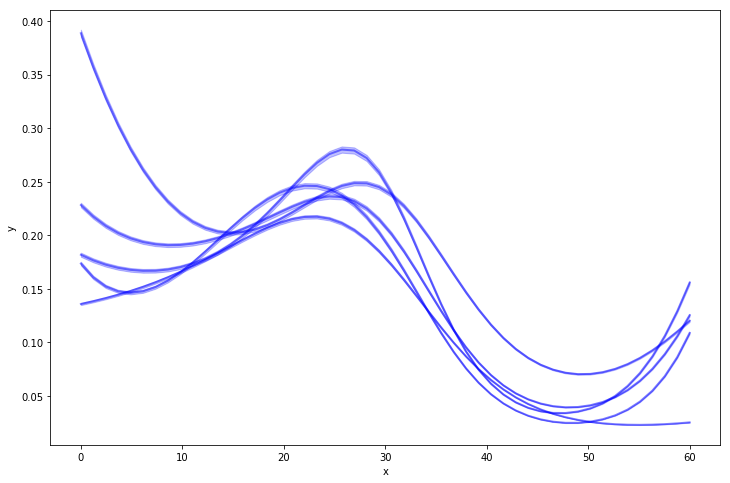

In [17]:
mini = 105
maxi = 110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanL[i,:], LowerL[i,:], UpperL[i,:])  

In [18]:
mean_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_n_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

In [19]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_n(xx)
    var1 = v1[:,:]
    mean_n_mat[i,:] = mean1[:,0]
    var_n_mat[i,:] = np.diag(var1)

std_n_mat = np.sqrt(var_n_mat)

In [20]:
LowerlogN = mean_n_mat - 2*std_n_mat
UpperlogN = mean_n_mat + 2*std_n_mat

In [21]:
MeanN = np.exp(mean_n_mat)
LowerN = np.exp(LowerlogN)
UpperN = np.exp(UpperlogN)

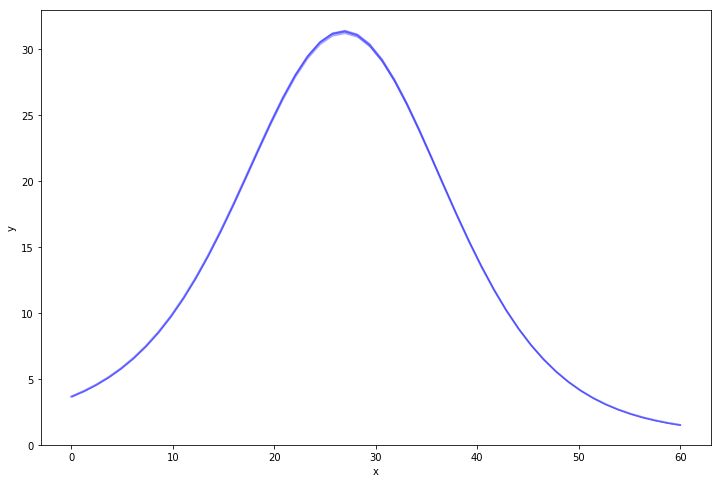

In [22]:
mini = 10
maxi = 11
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, MeanN[i,:], LowerN[i,:], UpperN[i,:])  

In [23]:
sig_samples = m.signal_variance.get_samples_df(samples)
signal_var = np.array([])
for s in sig_samples:
    signal_var = np.append(signal_var, s)

In [24]:
mean_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))
var_f_mat = np.zeros(shape = (samples.shape[0], xx.shape[0]))

for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean1, v1 = m.predict_f(xx)
    var1 = v1[:,:]
    mean_f_mat[i,:] = mean1[:,0]
    var_f_mat[i,:] = np.diag(var1)    

In [25]:
std_f_mat = np.sqrt(var_f_mat)

In [26]:
Lowerf = mean_f_mat - 2*std_f_mat
Upperf = mean_f_mat + 2*std_f_mat

In [27]:
def visualize(Xgrid, M, L, U):
    """
    Visualize 1D utility funciton values
    Xgrid : grid states
    Mgrid : mean of GP at those finite grid points
    Vargrid : variance of GP at those finite grid points
    """
    #plt.plot(X, Y, '.')
    
    line, = plt.plot(Xgrid, M, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L, U,
                     color = 'b', alpha = 0.25)
    #plt.fill_between(Xgrid[:,0], lower1, upper1,
    #                 color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

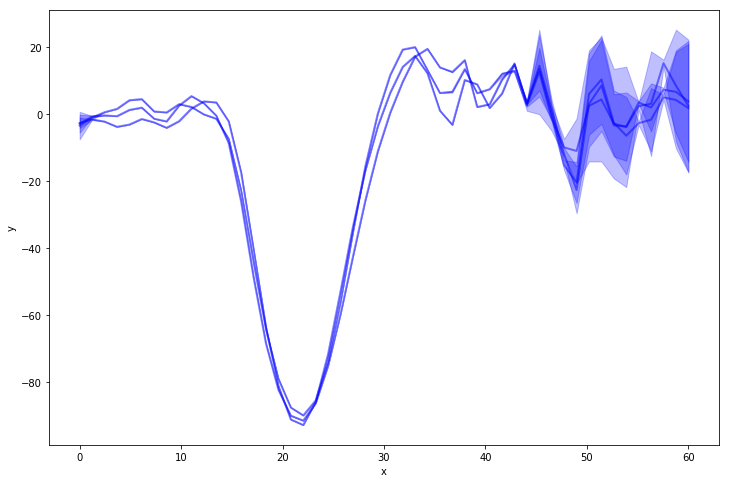

In [29]:
mini = 105
maxi = 108
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize(xnew, mean_f_mat[i,:], Lowerf[i,:], Upperf[i,:])  

In [30]:
def visualize_all(Xgrid, M1, L1, U1, U2, signal_var):
    """
    Visualize
    """
    M1 = np.sqrt(signal_var)*M1
    L1 = np.sqrt(signal_var)*L1
    U1 = np.sqrt(signal_var)*U1
    
    L2 = L1 - U2
    U2 = U1 + U2
    
    plt.plot(X, Y, '.')
    line, = plt.plot(Xgrid, M1, lw = 2, color = 'b', label = 'utility', alpha = 0.5)
    plt.fill_between(Xgrid[:,0], L1, U1,
                     color = 'b', alpha = 0.25)
    plt.fill_between(Xgrid[:,0], L2, U2,
                     color = 'g', alpha = 0.25)
    plt.xlabel('x')
    plt.ylabel('y')
    return

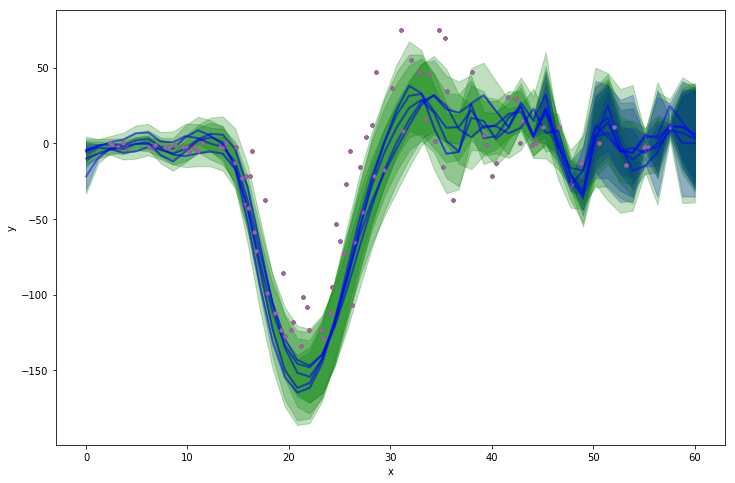

In [32]:
mini = 105
maxi = 110
plt.figure(figsize=(12,8))
for i in xrange(mini,maxi):
    visualize_all(xnew, mean_f_mat[i,:],
              Lowerf[i,:], Upperf[i,:],
              UpperN[i,:], signal_var[i])

In [ ]:
m